In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [63]:
def read_intensitylog(path):
    np_log = (pd.read_csv(path, delimiter=',')).to_numpy()

    # print(np_log.shape)

    return np_log

In [64]:
def percentile_rank_limit(p_rank, p_limit):
    '''Takes the percentile rank arr of a single patient and returns 
    the cut-off value of the given percentile (the last intensity we should include)'''
    arg_lst = np.argwhere(p_rank >= p_limit)
    
    if len(arg_lst) == 0:
        return len(p_rank) - 1
    
    return arg_lst[0]

def percentile_rank(patient, p_limit):
    '''patient; a numpy array (row) containing data of a single patient
    p_limit; the percentile rank one wants to maintain in the patient
    returns the patient data with removed outlines'''
    #hvis det skal laves til at køres på flere rækkker (flere patienter af gangen så sæt axis=1)
    cumFreq = np.cumsum(patient)
    
    #calculates the percentile rank for each bucket
    p_rank = (cumFreq - (0.5 * patient))/cumFreq[-1]*100

    last_bucket = percentile_rank_limit(p_rank, p_limit)

    #add out of bounds values into the last bucket
    patient[last_bucket] += sum(patient[(int(last_bucket) + 1):])

    #removes the last 1 - p% intensity values
    patient[(int(last_bucket) + 1):] = 0


    # patient[last_bucket] += (cumFreq[-1] - cumFreq[last_bucket])

    return patient


def cut_off_val(patient, p_limit):

    cumFreq = np.cumsum(patient)
    
    p_rank = (cumFreq - (0.5 * patient))/cumFreq[-1]*100

    limit_index = percentile_rank_limit(p_rank, p_limit)

    return patient[limit_index]

In [70]:
def remove_percentile_all(patientLogs, p_limit):
    #read_intensitylog(patientLogs)
    #we do not need to stack - er det den samme smarte måde du gør det på
    ret = np.zeros(patientLogs.shape, dtype=np.int64)

    for i in range(0, patientLogs.shape[0]):
        ret[i, :] = percentile_rank(patientLogs[i, :], p_limit)

    return ret






def plot_intensity(modality, arr, fname, deviations=True):
    y_values = np.sum(arr, axis=0)
    
    #if you want to plot the percentile for the entire dataset at once (not percentiles 
    #per patient but per modality)
    #y_values = arr
    
    # Compute mean and frequency based on modality
    if modality=='CT':
        x_values = np.arange(-1000, len(y_values) - 1000)
    
    elif modality =='MR':
        x_values = np.arange(len(y_values))

    elif modality == 'test':
        x_values = np.arange(len(y_values))
    else:
         return "Unknown modality: " + modality

    fx = y_values*(x_values)
    fx_squared = y_values*np.square(x_values)
    mean = np.sum(fx)/np.sum(y_values)

    #optional plotting of the standard deviation and the mean
    if deviations:
        fx = y_values*(x_values)
        fx_squared = y_values*np.square(x_values)
        mean = np.sum(fx)/np.sum(y_values)
        fx_squared = y_values*np.square(x_values)
        std = np.sqrt((np.sum(fx_squared)/np.sum(y_values))-mean)
        plt.axvline(mean, color='k', linestyle='dashed', linewidth=1, label=f'μ = {mean:.2f}')
        plt.axvline(mean+std, color='g', linewidth=1, label='μ + σ')
        # plt.axvline(mean-std, color='g', linewidth=1, label='μ - σ')
        plt.axvline(mean+std*2, color='b', linewidth=1, label='μ + 2σ')
        # plt.axvline(mean-std*2, color='b', linewidth=1, label='μ - 2σ')

    plt.scatter(x_values, y_values, c='firebrick')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency (pixels)')
    plt.title(fname)
    plt.yscale('log')  # Set y-axis scale to logarithmic
    plt.grid(True)
    plt.legend()
    plt.style.use('seaborn-v0_8')
    plt.savefig(fname)
    plt.show()


In [99]:
def cap_intensity(patientLogs, limit):

    values_exceeding_limit = np.sum(patientLogs[:,limit+1:])

    ret_arr = patientLogs.copy()[:,:limit+1]

    ret_arr[0,limit] += values_exceeding_limit

    return ret_arr


(357, 4001)
0.10196123930471453
(357, 3001)


In [66]:
#read logs
ct_log = read_intensitylog("np_ct_arr.csv")
mr_log = read_intensitylog("np_mr_arr.csv")

(357, 4001)
(357, 3001)


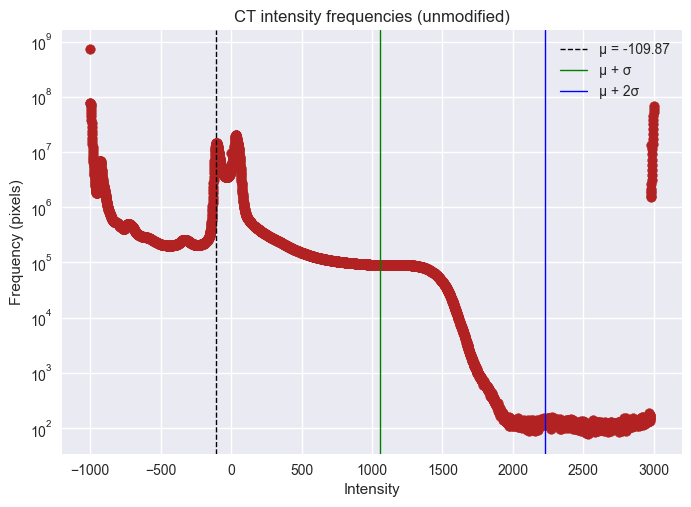

0.10196123930471453
(357, 3001)


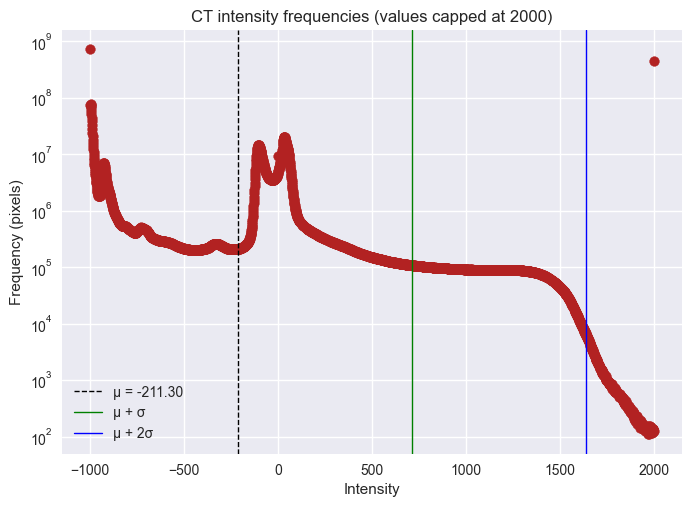

In [101]:
#ct
plot_intensity('CT', ct_log, 'CT intensity frequencies (unmodified)')

# ct_p95 = remove_percentile_all(ct_log, 95)

ct_capped = cap_intensity(ct_log,3000)

plot_intensity('CT', ct_capped, 'CT intensity frequencies (values capped at 2000)')

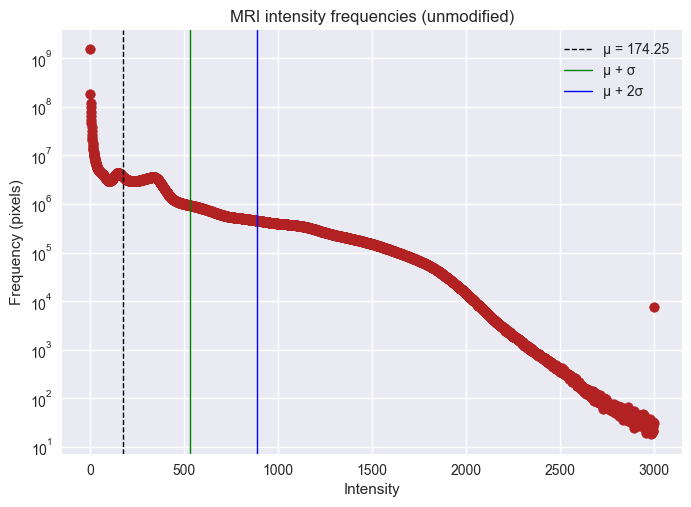

/var/folders/4m/3f6qk14n4899sdy94jn14yhm0000gn/T/ipykernel_60088/2437895621.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  patient[last_bucket] += sum(patient[(int(last_bucket) + 1):])
/var/folders/4m/3f6qk14n4899sdy94jn14yhm0000gn/T/ipykernel_60088/2437895621.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  patient[(int(last_bucket) + 1):] = 0
/var/folders/4m/3f6qk14n4899sdy94jn14yhm0000gn/T/ipykernel_60088/2437895621.py:19: RuntimeWarning: invalid value encountered in divide
  p_rank = (cumFreq - (0.5 * patient))/cumFreq[-1]*100


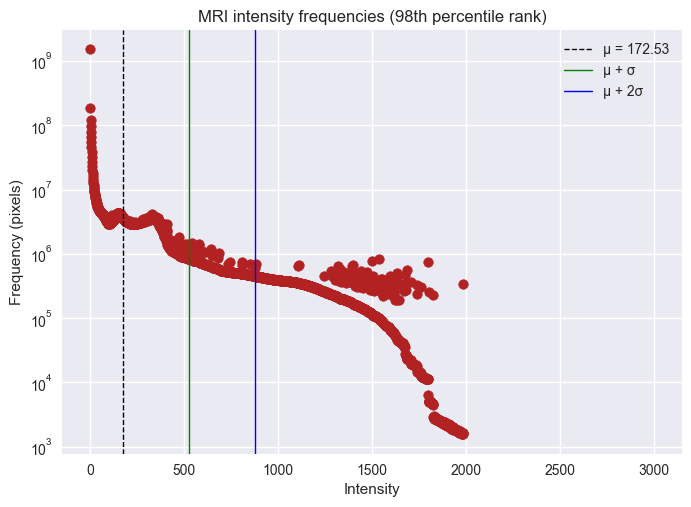

In [ ]:
plot_intensity('MR', mr_log, 'MRI intensity frequencies (unmodified)')
# plot_intensity('MR', remove_percentile_all(np.copy(mr_log), 99), 'mr_99')
plot_intensity('MR', remove_percentile_all(np.copy(mr_log), 98), 'MRI intensity frequencies (98th percentile rank)')
# plot_intensity('MR', remove_percentile_all(np.copy(mr_log), 95), 'mr_95')



In [ ]:
#tests
'''
a = np.array(([156, 136, 35, 14, 75, 1, 45, 23, 30],
              [100, 144, 44, 82, 6, 9, 8, 2, 1],
              [194, 185, 76, 65, 45, 44, 53, 2, 1],
              [200, 185, 76, 65, 125, 4, 3, 2, 1]))

plot_intensity('test', a)

ret = remove_percentile_all(a, 50)

plot_intensity('test', ret)

rand_arr = np.random.randint(low=1, high=3000,size=(258, 4001))

(pd.DataFrame(rand_arr)).to_csv('randCT.csv', index=False)

ct_test = read_intensitylog(r"C:\Users\Emily Honey\MRI2CT\MAKEDATA\randCT.csv")

plot_intensity('CT', ct_test, 'ct_test')

no_per = remove_percentile_all(ct_test, 95)
plot_intensity('CT', no_per, 'ct_test_percentile')'''


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 457-458: truncated \UXXXXXXXX escape (2108395562.py, line 2)